In [12]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print("train mask: ", data.train_mask.sum())
print("validation mask: ", data.val_mask.sum())
print("test mask: ", data.test_mask.sum())
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
train mask:  tensor(140)
validation mask:  tensor(500)
test mask:  tensor(1000)
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [2]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


out tensor([ 0.2398, -0.4626, -0.2138,  2.3141,  0.7556, -0.0861, -1.1711],
       grad_fn=<SelectBackward0>)
zzz [[-15.426829  48.06001 ]
 [-51.864216   2.462826]
 [-49.896885   7.931928]
 ...
 [ 14.366923 -32.627426]
 [-24.021198  40.75427 ]
 [-22.876287  40.073032]]


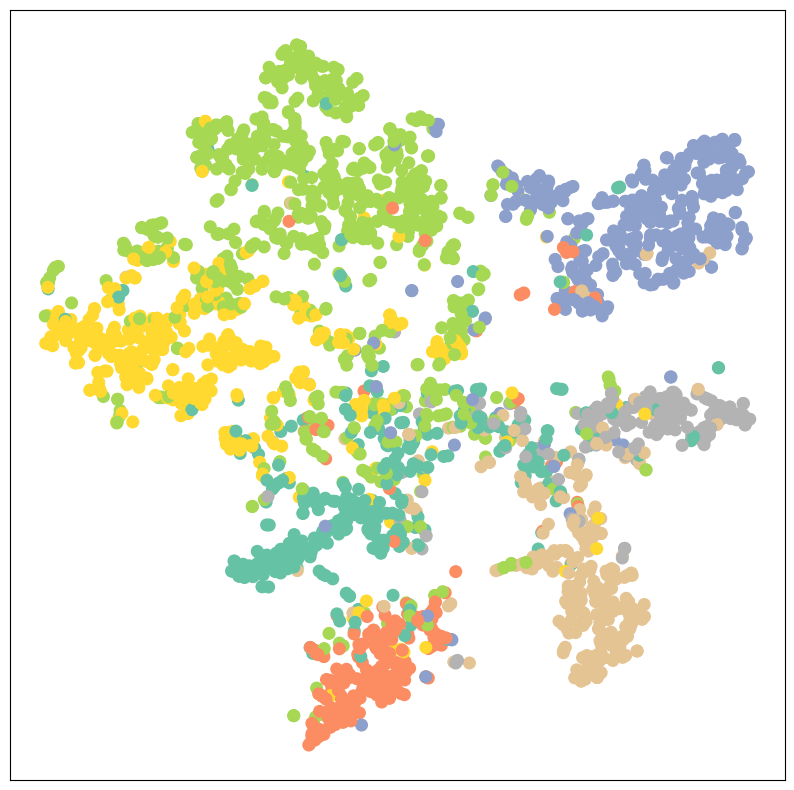

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    print('zzz', z)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
model.eval()
out = model(data.x, data.edge_index)
print("out", out[0])
visualize(out, color=data.y)


In [4]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc


val_acc_all = []
test_acc_all = []
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')



Epoch: 001, Loss: 1.9465, Val: 0.1660, Test: 0.1630
Epoch: 002, Loss: 1.9419, Val: 0.3220, Test: 0.3800
Epoch: 003, Loss: 1.9363, Val: 0.1880, Test: 0.2200
Epoch: 004, Loss: 1.9290, Val: 0.1780, Test: 0.2060
Epoch: 005, Loss: 1.9199, Val: 0.2280, Test: 0.2680
Epoch: 006, Loss: 1.9140, Val: 0.2800, Test: 0.3250
Epoch: 007, Loss: 1.9079, Val: 0.3440, Test: 0.3740
Epoch: 008, Loss: 1.8992, Val: 0.3740, Test: 0.4030
Epoch: 009, Loss: 1.8876, Val: 0.4040, Test: 0.4380
Epoch: 010, Loss: 1.8764, Val: 0.4280, Test: 0.4760
Epoch: 011, Loss: 1.8656, Val: 0.4660, Test: 0.4950
Epoch: 012, Loss: 1.8626, Val: 0.4840, Test: 0.5200
Epoch: 013, Loss: 1.8460, Val: 0.5080, Test: 0.5280
Epoch: 014, Loss: 1.8329, Val: 0.5200, Test: 0.5320
Epoch: 015, Loss: 1.8225, Val: 0.5280, Test: 0.5380
Epoch: 016, Loss: 1.8167, Val: 0.5520, Test: 0.5730
Epoch: 017, Loss: 1.7995, Val: 0.5880, Test: 0.5930
Epoch: 018, Loss: 1.7878, Val: 0.6080, Test: 0.6250
Epoch: 019, Loss: 1.7716, Val: 0.6100, Test: 0.6350
Epoch: 020, 

In [6]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


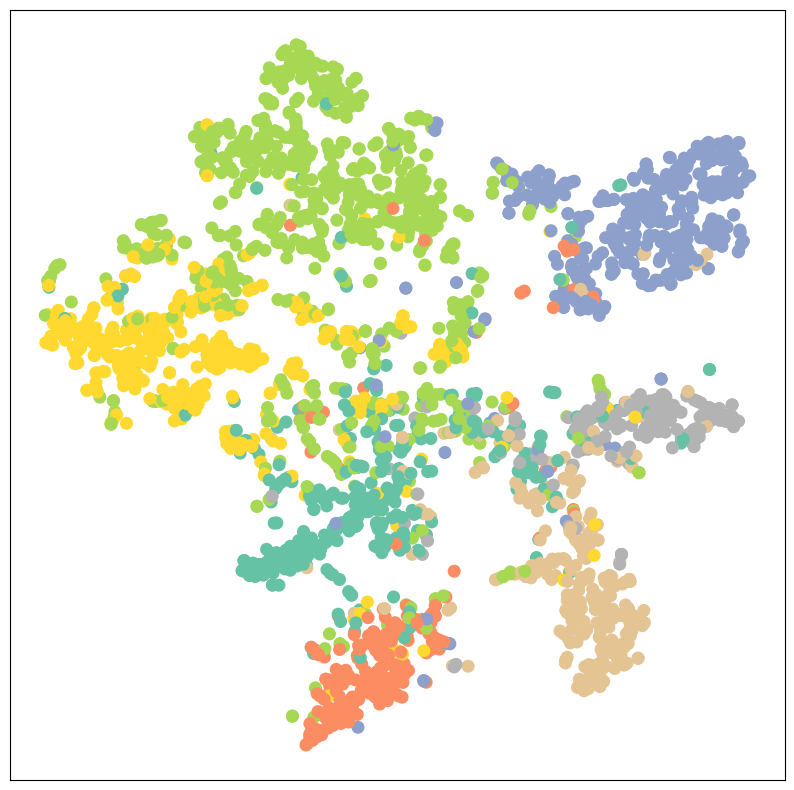

In [7]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)